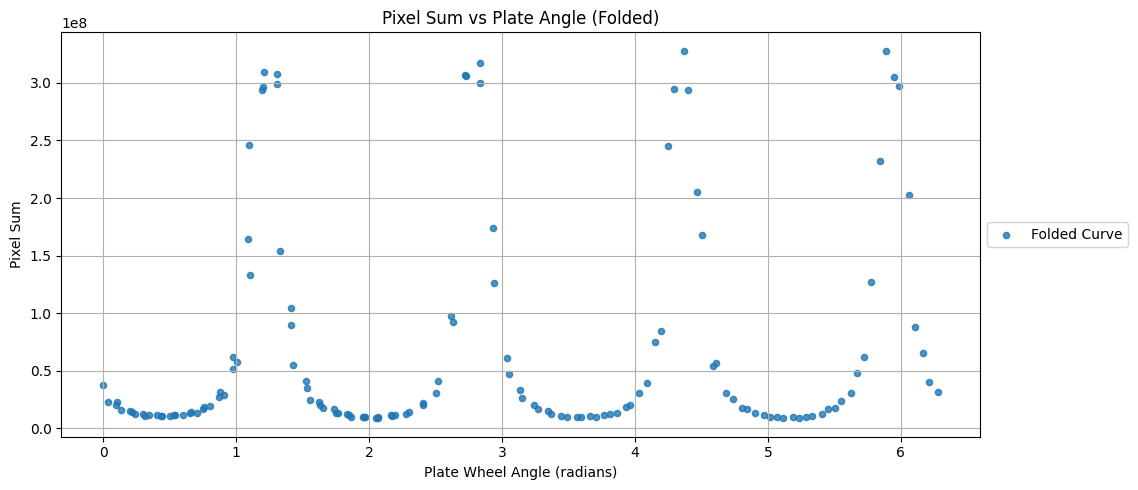

In [28]:
# Polarimeter Curve Folding Notebook

import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from datetime import datetime, timezone, timedelta
import pickle
from glob import glob

# === PARAMETERS ===

# Change this to your data
fits_dir = "/home/declan/RPI/readout/exposures-20250620-184353-495/"
encoder_pkl = "/home/declan/RPI/motor/encoder_data_20250620_184958.pkl"

counts_per_wheel_rev_guess = 2410  # Guess and adjust this
timezone_offset_hours = 4  # if FITS timestamps are in local time

# === Load encoder data ===

with open(encoder_pkl, "rb") as f:
    enc_data = pickle.load(f)

encoder_times_ms = np.array(list(enc_data.keys()))
encoder_counts = np.array(list(enc_data.values()))

# Convert to datetime in UTC
encoder_times = np.array([
    datetime.fromtimestamp(ms / 1000.0, tz=timezone.utc)
    for ms in encoder_times_ms
])

# === Load FITS data ===

fits_path = os.path.join(fits_dir, "processed", "fits")
fits_files = sorted(glob(os.path.join(fits_path, "*.fits")))

fits_times = []
pixel_sums = []
plate_angles_raw = []

for ffile in fits_files:
    header = fits.getheader(ffile)
    date_obs = header.get("DATE-OBS")
    if date_obs is None:
        continue

    fits_time = datetime.fromisoformat(date_obs.replace("Z", "+00:00")) + timedelta(hours=timezone_offset_hours)
    fits_time = fits_time.replace(tzinfo=timezone.utc)

    fits_ts = fits_time.timestamp()
    encoder_ts = np.array([et.timestamp() for et in encoder_times])

    if fits_ts < encoder_ts[0] or fits_ts > encoder_ts[-1]:
        continue

    idx = np.searchsorted(encoder_ts, fits_ts)
    if idx >= len(encoder_counts):
        continue
    # choose closer of two nearest
    before, after = encoder_ts[idx - 1], encoder_ts[idx] if idx < len(encoder_ts) else encoder_ts[-1]
    closest_idx = idx - 1 if abs(fits_ts - before) < abs(fits_ts - after) else idx

    encoder_value = encoder_counts[closest_idx]

    # Load image and sum pixel values
    data = fits.getdata(ffile)
    pixel_sum = np.sum(data)

    pixel_sums.append(pixel_sum)
    plate_angles_raw.append(encoder_value)
    fits_times.append(fits_time)

# === Compute Plate Angles and Fold ===

plate_angles_raw = np.array(plate_angles_raw)
pixel_sums = np.array(pixel_sums)

# Normalize counts relative to first frame
relative_counts = plate_angles_raw - plate_angles_raw[0]

# Convert to wheel rotation angle in radians
wheel_fraction = (relative_counts / counts_per_wheel_rev_guess) % 1
wheel_angles_rad = wheel_fraction * 2 * np.pi

# === Plot ===

plt.figure(figsize=(10, 5))
plt.scatter(wheel_angles_rad, pixel_sums, s=20, alpha=0.8, label="Folded Curve")
plt.xlabel("Plate Wheel Angle (radians)")
plt.ylabel("Pixel Sum")
plt.title("Pixel Sum vs Plate Angle (Folded)")
plt.grid(True)
plt.tight_layout()
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()